<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Можно ли использовать сверточные сети для классификации текстов? Если нет обоснуйте :D, если да то как? как решить проблему с произвольной длинной входа?

<Ответ>

**Вопрос 2**: Чем LSTM лучше/хуже чем обычная RNN?

<Ответ>Обычная RNN хорошо работает когда новый ответ сильно зависит от нескольких предыдущих ответов, но когда зависимости возникают от более отдалённых ответов, то RNN начинает работать хуже. LSTM решает проблему, вводя вектор-состояние и производя более сложную процедуру между состоянием $c_{t-1}$, прошлым результатом $h_{t-1}$, и входом $x_{t}$. Как следствие такие сети дольше обучаются, но гораздо лучше справляются с зависимостями, где ответ может зависить от слиьно старых ответов.

**Вопрос 3**:  Выпишите производную $\frac{d c_{n+1}}{d c_{k}}$ для LSTM http://colah.github.io/posts/2015-08-Understanding-LSTMs/, объясните формулу, когда производная затухает, когда взрывается?

<Ответ>$\frac{d c_{n+1}}{d c_{k}} = \frac{d c_{n+1}}{d c_{n}}\frac{d c_{n}}{d c_{k}} = diag(\sigma(x_{n+1},h_{n}))\frac{d c_{n}}{d c_{k}} = diag(\prod_{i=k}^{n}\sigma(x_{i+1},h_{i}))$ (Где $\prod$ - поэлементное произведение.) Если несколько компонент $x_{i}$ значительно меньше остальных, то градиент затухнет. Поскольку на каждом этапе берётся so

**Вопрос 4**: Зачем нужен TBPTT почему BPTT плох?

<Ответ>Главная проблема BPTT - затухание градиента. Truncated BPTT борется с этим, запуская BPTT на $k2$ шагов каждые $k1 $ шагов.


**Вопрос 5**: Как комбинировать рекуррентные и сверточные сети, а главное зачем? Приведите несколько примеров реальных задач.

<Ответ> Можно по картинкам генерировать текст или звук, можно генерировать подписи к музыке

**Вопрос 6**: Объясните интуицию выбора размера эмбединг слоя? почему это опасное место?

<Ответ> Если сильно промохнуться с размерностью, то взаимный смысл слов не сохранится

* Arseniy Ashuha, you can text me ```ars.ashuha@gmail.com```, Александр Панин

<h1 align="center"> Image Captioning </h1> 

In this seminar you'll be going through the image captioning pipeline. It can help u https://ars-ashuha.ru/slides/2016.11.11_ImageCaptioning/image_captionong.pdf 

To begin with, let us download the dataset of image features from a pre-trained GoogleNet.

In [1]:
#!wget https://www.dropbox.com/s/3hj16b0fj6yw7cc/data.tar.gz?dl=1 -O data.tar.gz
!tar -xvzf data.tar.gz

data/caption_tokens.pcl
data/
data/image_codes.npy
data/raw_captions.pcl
data/Dog-and-Cat.jpg
data/blvc_googlenet.pkl


### Data preprocessing

In [1]:
%%time
# Read Dataset
import numpy as np
import pickle

img_codes = np.load("data/image_codes.npy")
captions = pickle.load(open('data/caption_tokens.pcl', 'rb'))

CPU times: user 2.77 s, sys: 1.06 s, total: 3.83 s
Wall time: 3.73 s


In [2]:
print "each image code is a 1000-unit vector:", img_codes.shape
print img_codes[0,:10]
print '\n\n'
print "for each image there are 5-7 descriptions, e.g.:\n"
print '\n'.join(captions[0])

each image code is a 1000-unit vector: (123287, 1000)
[ 1.38901556 -3.82951474 -1.94360816 -0.5317238  -0.03120959 -2.87483215
 -2.9554503   0.6960277  -0.68551242 -0.7855981 ]



for each image there are 5-7 descriptions, e.g.:

a man with a red helmet on a small moped on a dirt road
man riding a motor bike on a dirt road on the countryside
a man riding on the back of a motorcycle
a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud wreathed mountains
a man in a red shirt and a red hat is on a motorcycle on a hill side


In [3]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

In [4]:
# Build a Vocabulary

############# TO CODE IT BY YOURSELF ##################
from collections import defaultdict
word_counts = defaultdict(int)
for caption in captions:
    for cap in caption:
        for word in cap[1:-1]:         #I don't add '#START#', '#END#', since they are already in vocabulary
            word_counts[word] += 1

vocab  = ['#UNK#', '#START#', '#END#']
vocab += [k for k, v in word_counts.items() if v >= 5]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [5]:
PAD_ix = -1
UNK_ix = vocab.index('#UNK#')

def as_matrix(sequences,max_len=None):
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int32')+PAD_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word,UNK_ix) for word in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix

In [6]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[    1,  2852,  7829,  4136, 10056,  9932,  5915,  4859,  6766,
         1244,  3980,  6254,     2,    -1,    -1],
       [    1,  6766,  1244,  8900,  1022,  9093,  6254,  3980,  8255,
          728,  5915,     2,    -1,    -1,    -1],
       [    1,  8715,  4136, 10056,  9932,  5915,  4859,  6766,  5627,
         8637,   535,  5470,  7115,  5155,     2],
       [    1,  8715,  8895,  3069,  2538,   782,  8715,  8895,  1559,
            2,    -1,    -1,    -1,    -1,    -1],
       [    1,  2852,  7829,  4136, 10056,  9932,  5915,  4859,  6766,
         1244,   535,  5470,  8917,     2,    -1]], dtype=int32)

### Mah Neural Network

In [195]:
# network shapes. 
CNN_FEATURE_SIZE = img_codes.shape[1]
EMBED_SIZE = 800 #pls change me if u want
LSTM_UNITS = 1200 #pls change me if u want
DROPOUT_PROB = 0.5
GRAD_CLIPPING = 5

In [196]:
import theano
import lasagne
import theano.tensor as T
from lasagne.layers import *

In [197]:
# Input Variable
sentences = T.imatrix()# [batch_size x time] of word ids
image_vectors = T.matrix() # [batch size x unit] of CNN image features
sentence_mask = T.neq(sentences, PAD_ix)

In [198]:
#network inputs
l_words = InputLayer((None, None), sentences)
l_mask = InputLayer((None, None), sentence_mask)

#embeddings for words 
############# TO CODE IT BY YOURSELF ##################
l_word_embeddings = EmbeddingLayer(l_words, len(vocab), EMBED_SIZE)

In [199]:
# input layer for image features
l_image_features = InputLayer((None, CNN_FEATURE_SIZE), image_vectors)

############# TO CODE IT BY YOURSELF ##################
#convert 1000 image features from googlenet to whatever LSTM_UNITS you have set
#it's also a good idea to add some dropout here and there
l_image_features_small = DropoutLayer(l_image_features, DROPOUT_PROB)#<Apply Dropout Layer to regularise your Net>
l_image_features_small = DenseLayer(l_image_features_small, LSTM_UNITS)#<Apply Dense to acive LSTM_UNITS size of representation>
assert l_image_features_small.output_shape == (None, LSTM_UNITS)

In [200]:
############# TO CODE IT BY YOURSELF ##################
# Concatinate image features and word embedings in one sequence 
decoder = LSTMLayer(l_word_embeddings,#<Hmmm, what whould be here?>,
                    num_units=LSTM_UNITS,
                    cell_init=l_image_features_small,
                    mask_input=l_mask,
                    grad_clipping=GRAD_CLIPPING)

In [201]:
# Decoding of rnn hiden states
from broadcast import BroadcastLayer,UnbroadcastLayer

#apply whatever comes next to each tick of each example in a batch. Equivalent to 2 reshapes
broadcast_decoder_ticks = BroadcastLayer(decoder, (0, 1))
print "broadcasted decoder shape = ",broadcast_decoder_ticks.output_shape

predicted_probabilities_each_tick = DenseLayer(
    broadcast_decoder_ticks,n_tokens, nonlinearity=lasagne.nonlinearities.softmax)

#un-broadcast back into (batch,tick,probabilities)
predicted_probabilities = UnbroadcastLayer(
    predicted_probabilities_each_tick, broadcast_layer=broadcast_decoder_ticks)

print "output shape = ", predicted_probabilities.output_shape

#remove if you know what you're doing (e.g. 1d convolutions or fixed shape)
assert predicted_probabilities.output_shape == (None, None, 10371) #not 10373 since I didn't add #START# and #END# 
                                                                   #the second time to vocab

broadcasted decoder shape =  (None, 1200)
output shape =  (None, None, 10371)


In [202]:
next_word_probas = get_output(predicted_probabilities)

reference_answers = sentences[:,1:]
output_mask = sentence_mask[:,1:]

#write symbolic loss function to train NN for
loss = lasagne.objectives.categorical_crossentropy(
    next_word_probas[:, :-1].reshape((-1, n_tokens)),
    reference_answers.reshape((-1,))
).reshape(reference_answers.shape)

############# TO CODE IT BY YOURSELF ##################
loss = (output_mask * loss).sum() / output_mask.sum()

In [203]:
learning_rate = theano.shared(lasagne.utils.floatX(0.0016))

In [204]:
#trainable NN weights
############# TO CODE IT BY YOURSELF ##################
weights = get_all_params(predicted_probabilities, trainable=True)
updates = lasagne.updates.adam(loss, weights, learning_rate=learning_rate)

In [205]:
#compile a function that takes input sentence and image mask, outputs loss and updates weights
#please not that your functions must accept image features as FIRST param and sentences as second one
############# TO CODE IT BY YOURSELF ##################
train_step = theano.function([image_vectors, sentences], loss, updates=updates, allow_input_downcast=True)
val_step   = theano.function([image_vectors, sentences], loss, allow_input_downcast=True)

# Training

* You first have to implement a batch generator
* Than the network will get trained the usual way

In [206]:
captions = np.array(captions)

In [207]:
from random import choice

def generate_batch(images,captions,batch_size,max_caption_len=None):
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(images), size=batch_size)
    
    #get images
    batch_images = images[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick 1 from 5-7 captions for each image
    batch_captions = map(choice, captions_for_batch_images)
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return batch_images, batch_captions_ix

In [208]:
generate_batch(img_codes,captions, 3)

(array([[ 1.02774107, -1.50088108,  0.56453329, ...,  0.33076435,
          3.23889494,  0.70725948],
        [-5.62007523, -4.70356226,  0.10609702, ..., -2.70333195,
         -0.89375222,  4.61910582],
        [-1.54739463,  4.60542488, -1.4693712 , ...,  2.93248487,
          4.34635973, -0.27075052]], dtype=float32),
 array([[   1, 8715, 8895,  595,  782, 3323, 4364, 4859, 8715, 8532,  999,
          326, 5434, 8532, 1854,    2],
        [   1, 8715, 8895, 8239, 4610, 1111, 8715, 1381, 7040,    2,   -1,
           -1,   -1,   -1,   -1,   -1],
        [   1, 8715, 5824, 3974, 3431,  782, 1215, 5954,  326, 3159,    2,
           -1,   -1,   -1,   -1,   -1]], dtype=int32))

### Main loop
* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again

In [209]:
batch_size = 75 #adjust me
n_epochs   = 150 #adjust me
n_batches_per_epoch = 75 #adjust me
n_validation_batches = 10 #how many batches are used for validation after each epoch

In [210]:
train_hist = []
val_hist = []

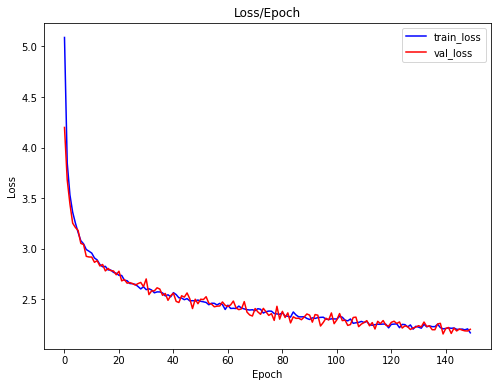


Epoch: 149, train loss: 2.1686813275, val loss: 2.20354135036, rate: 0.000335544289555
Finish :)


In [211]:
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

for epoch in range(n_epochs):
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes,captions,batch_size))
    train_loss /= n_batches_per_epoch
    train_hist.append(train_loss)
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    val_hist.append(val_loss)
        
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
    plt.title("Loss/Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(train_hist, 'b', label='train_loss')
    plt.plot(val_hist, 'r', label='val_loss')
    plt.legend(loc='best')
    plt.show()
    
    print('\nEpoch: {}, train loss: {}, val loss: {}, rate: {}'.format(epoch, train_loss, val_loss,
                                                                       learning_rate.get_value()))
    if epoch % 20 == 0 and epoch != 0:
        rate = theano.shared(lasagne.utils.floatX(learning_rate.get_value() * 0.8))
        if rate.get_value() > 0.1**(5):
            learning_rate.set_value(lasagne.utils.floatX(rate.get_value()))

print("Finish :)")

### apply trained model

In [212]:
#the same kind you did last week, but a bit smaller
from pretrained_lenet import build_model,preprocess,MEAN_VALUES

# build googlenet
lenet = build_model()

#load weights
lenet_weights = pickle.load(open('data/blvc_googlenet.pkl'))['param values']
set_all_param_values(lenet["prob"], lenet_weights)

#compile get_features
cnn_input_var = lenet['input'].input_var
cnn_feature_layer = lenet['loss3/classifier']
get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

In [213]:
from matplotlib import pyplot as plt
%matplotlib inline

#sample image
img = plt.imread('data/Dog-and-Cat.jpg')
img = preprocess(img)

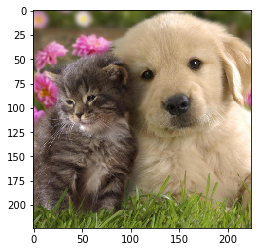

In [214]:
#deprocess and show, one line :)
from pretrained_lenet import MEAN_VALUES
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

## Generate caption

In [215]:
last_word_probas_det = get_output(predicted_probabilities,deterministic=False)[:,-1]

get_probs = theano.function([image_vectors,sentences], last_word_probas_det)

#this is exactly the generation function from week5 classwork,
#except now we condition on image features instead of words
def generate_caption(image,caption_prefix = ("START",),t=1,sample=True,max_len=100):
    image_features = get_cnn_features(image)
    caption = list(caption_prefix)
    for _ in range(max_len):
        
        next_word_probs = get_probs(image_features,as_matrix([caption]) ).ravel()
        #apply temperature
        next_word_probs = next_word_probs**t / np.sum(next_word_probs**t)

        if sample:
            next_word = np.random.choice(vocab,p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption.append(next_word)

        if next_word=="#END#":
            break
            
    return caption

In [227]:
for i in range(10):
    print ' '.join(generate_caption(img,t=2)[1:-1])

a white cat is sitting on a wooden bench
a black and white cat is sitting in a red chair
a little cat sitting on top of a wooden chair
a woman is holding a small dog in his arms
a cat sitting on top of a wooden bench
a close up of a cat laying on a small table
a cat is sitting in a chair with a stuffed animal
a cat is sitting in a chair on a table
a little white and brown cat sitting on a chair
a fluffy cat is laying down on a bed


# Bonus Part
- Use ResNet Instead of GoogLeNet
- Use W2V as embedding
- Use Attention :) 

# Pass Assignment https://goo.gl/forms/2qqVtfepn0t1aDgh1 